# Lab: cleaning numeric data

##     Import the necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

##     Load the we_fn_use_c_marketing_customer_value_analysis.csv into the variable customer_df


In [2]:
customer_df = pd.read_csv('files_for_lab/we_fn_use_c_marketing_customer_value_analysis.csv')

##     First look at its main features (head, shape, info).


In [3]:
pd.set_option('display.max_columns', None)
customer_df.head(60)

In [ ]:
customer_df.shape

In [ ]:
customer_df.info()

In [ ]:
customer_df.describe()

##     Rename the columns so they follow the PE8 (snake case) (lower_case_with_underscores)


In [4]:
columnnames = [column.replace(' ','_').lower() for column in customer_df.columns]

customer_df.columns = columnnames

##     Change effective to date column to datetime format.


In [5]:
newdata = []

for row in customer_df['effective_to_date']:
    month, day, year = row.split('/')
    year = '20' + year
    newdata.append(datetime.datetime(int(year), int(month), int(day)))

customer_df['effective_to_date'] = newdata

customer_df['effective_to_date']

0      2011-02-24
1      2011-01-31
2      2011-02-19
3      2011-01-20
4      2011-02-03
          ...    
9129   2011-02-10
9130   2011-02-12
9131   2011-02-06
9132   2011-02-03
9133   2011-02-14
Name: effective_to_date, Length: 9134, dtype: datetime64[ns]

##     Define a function that differentiates between continuous and discrete variables. Hint: The number of unique values might be useful. Store continuous data into a continuous_df variable and do the same for discrete_df


First of all: all categorical data is discrete - so the real work in the function will be done on numerical data. 

In [6]:
# So I'll use the numerical columns for now

num_df = customer_df.select_dtypes(include = np.number)

num_df

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount
0,2763.519279,56274,69,32,5,0,1,384.811147
1,6979.535903,0,94,13,42,0,8,1131.464935
2,12887.431650,48767,108,18,38,0,2,566.472247
3,7645.861827,0,106,18,65,0,7,529.881344
4,2813.692575,43836,73,12,44,0,1,138.130879
...,...,...,...,...,...,...,...,...
9129,23405.987980,71941,73,18,89,0,2,198.234764
9130,3096.511217,21604,79,14,28,0,1,379.200000
9131,8163.890428,0,85,9,37,3,2,790.784983
9132,7524.442436,21941,96,34,3,0,3,691.200000


In [7]:
# I'll follow the hint first and retrieve the number of unique values: 

for column in num_df:
    print (column, ' ', len(pd.unique(num_df[column])))

customer_lifetime_value   8041
income   5694
monthly_premium_auto   202
months_since_last_claim   36
months_since_policy_inception   100
number_of_open_complaints   6
number_of_policies   9
total_claim_amount   5106


This is helpful: the highest value for discrete variables is 100 (number of months), the lowest for continuous variables is 202 (monthly premium). So I'll use 150 as a cutoff point here. 

I'm not 100% sure if the categorical columns count as 'discrete', or if I should just take the numerical ones. I'll write the function generously, so that it could go either way depending on the input:

In [8]:
def discont(dataframe):
    # First initialize a discrete dataframe. 

    
    # Either and populate it with the categorical columns (which are all discrete), 
    if len(list(dataframe.select_dtypes(object))) > 0:
        discrete_df = dataframe.select_dtypes(include = object)
    # Or if there are no categorical columns, just initialize it. 
    else: 
        discrete_df = pd.DataFrame()
        
        
    # Next initialize a continuous dataframe (empty for now)
    continuous_df = pd.DataFrame()
    
    
    # Then initialize a dataframe with just numerical data
    numerical_df = dataframe.select_dtypes(include = np.number)
    
    
    # Then iterate over numerical columns, adding those where the number of values < 150 to discrete, the others to continuous.
    for column in numerical_df:
        if len(pd.unique(numerical_df[column])) < 150: 
            discrete_df = pd.concat([discrete_df, dataframe[column]], axis = 1)
        else: 
            continuous_df = pd.concat([continuous_df, dataframe[column]], axis = 1)   
    
    #And return
    return continuous_df, discrete_df

In [9]:
continuous_df, discrete_df = discont(num_df)

In [ ]:
continuous_df.head()

##    Plot a correlation matrix, comment what you see.


<AxesSubplot:>

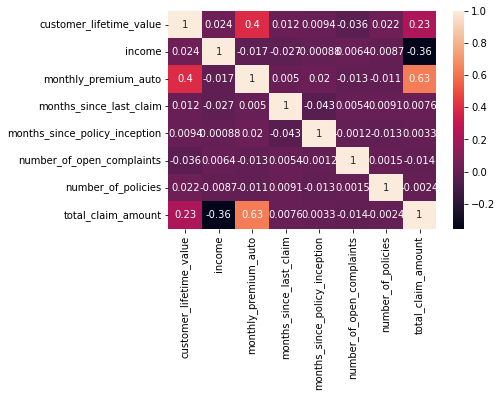

In [10]:
sns.heatmap(customer_df.corr(),annot=True)

Low correlations almost everywhere. The most promising line here is to use total_claim_amount as the target value, and customer_lifetime_value, income, and monthly_premium_auto as features. 

However, there may be multicollinearity between customer_lifetime_value and monthly_premium_auto - which makes sense: a higher monthly premium over time will amount to a higher lifetime value. So I'll have to tread lightly.

##     Create a function to plot every discrete variable. Do the same with the continuous variables (Be Careful, you may need to change the plot type to one better suited for continuous data!)


In [11]:
def discreteplot(dataframe):
    for column in dataframe: 
        sns.displot(dataframe[column])
        plt.show()
    return

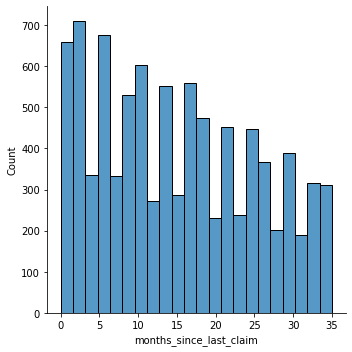

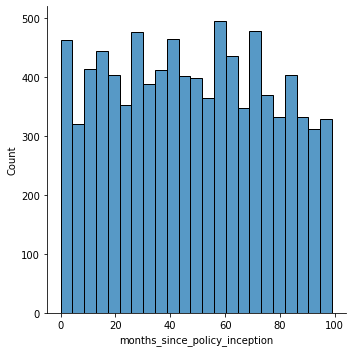

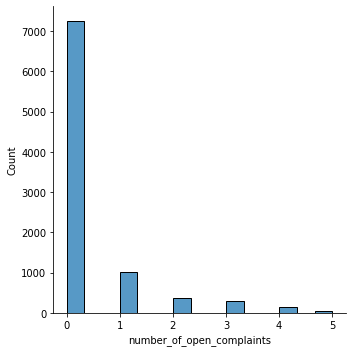

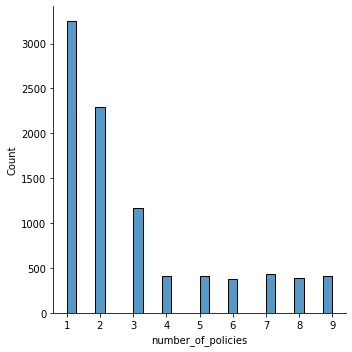

In [12]:
discreteplot(discrete_df)

In [13]:
def contplot(dataframe):
    for column in dataframe: 
        sns.displot(dataframe[column], kde = True)
        plt.show()
    return

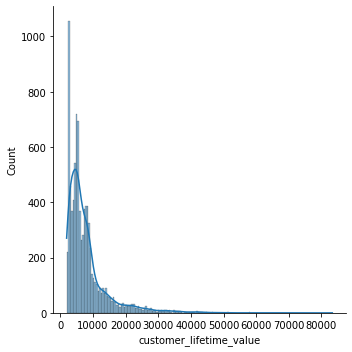

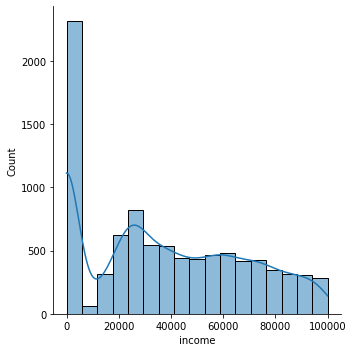

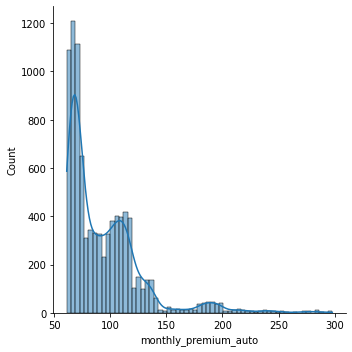

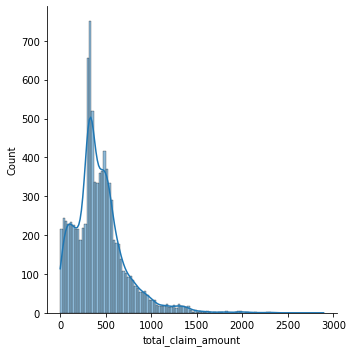

In [14]:
contplot(continuous_df)

##     Comment what you can see in the plots.


In the discrete part of the world, the months since policy inception may have a normal distribution, while the other ones all tend to get lower counts as the value increases.

In the continuous data, the two things that meet the eye are: 
- Income is heavily skewed around 0. I'd have to check if those really are 0s - and if so, if they should really count as NaNs.
- The other variables (other than income) all appear to have pretty significant outliers on the higher end of the spectrum. That would need some looking at. 

##     Look for outliers in the continuous variables. (HINT: There’s a good plot to do that!)


Boxplot time! I'll write a new function to get boxplots for all continuous variables in less code.

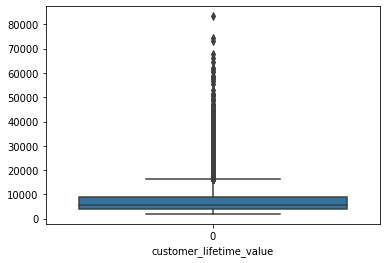

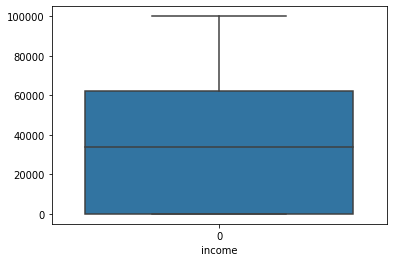

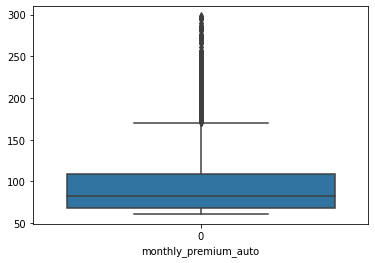

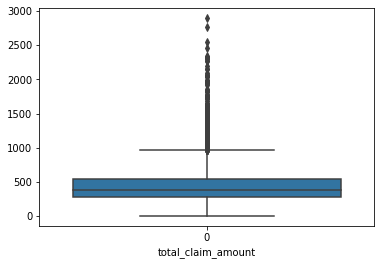

In [15]:
def contboxplot(dataframe):
    for column in dataframe: 
        sns.boxplot(dataframe[column]).set(xlabel = column)
        plt.show()
    return

contboxplot(continuous_df)

##     Did you find outliers? Comment what you will do with them.


In customer lifetime value and total claim amount, the outliers seem particularly high and increasingly rare towards the higher end of the spectrum. In monthly premium, it looks a little less skewed. 

I would eliminate outliers from total_claim_amount and customer_lifetime_value, taking the 75th percentile + 1.5 x iqr as the limit. 

In [16]:
def get_upper_limit(dataframe, column):
    iqr = np.nanpercentile(dataframe[column],75) - np.nanpercentile(dataframe[column],25)
    upper_limit = (np.nanpercentile(dataframe[column],75) + 1.5 *iqr)
    return upper_limit

In [17]:
# Apply that function to the relevant columns:

get_upper_limit(continuous_df, 'customer_lifetime_value')

16414.039911750002

In [18]:
get_upper_limit(continuous_df, 'total_claim_amount')

960.3997301249999

Hmmm - these seem to be overly restrictive here. So I won't go with that. Instead, I'll do a log transformation on the data.

In [19]:
def log_transform_clean(x):
    if x>0:
        return np.log(x)
    else:
        return np.NAN 

<AxesSubplot:>

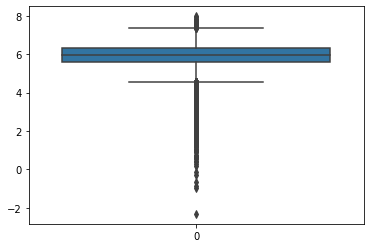

In [20]:
total_claim_log = continuous_df['total_claim_amount'].apply(log_transform_clean)
sns.boxplot(total_claim_log)

I'm actually not too happy with this one - the lower end of the spectrum gets torn apart a bit much. But I'll stick with it for now (and hope for productive feedback!)

<AxesSubplot:>

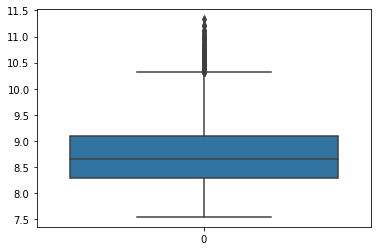

In [21]:
customer_lifetime_log = continuous_df['customer_lifetime_value'].apply(log_transform_clean)
sns.boxplot(customer_lifetime_log)

I realize now that this will end up being the target variable, so there's no point in applying the log regression here. It'll be the y value later on, so I'll leave it untouched.

##    Check all columns for NaN values. Decide what (if anything) you will need to do with them.


In [22]:
customer_df.isna().sum()

customer                         0
state                            0
customer_lifetime_value          0
response                         0
coverage                         0
education                        0
effective_to_date                0
employmentstatus                 0
gender                           0
income                           0
location_code                    0
marital_status                   0
monthly_premium_auto             0
months_since_last_claim          0
months_since_policy_inception    0
number_of_open_complaints        0
number_of_policies               0
policy_type                      0
policy                           0
renew_offer_type                 0
sales_channel                    0
total_claim_amount               0
vehicle_class                    0
vehicle_size                     0
dtype: int64

No NaN, no problem! 

BUT: Income was a potential source of NaNs, if there are a lot of 0s in there.

In [23]:
customer_df['income'].value_counts()

0        2317
95697      12
27972       7
25370       7
61108       7
         ... 
36529       1
25859       1
38179       1
70190       1
21941       1
Name: income, Length: 5694, dtype: int64

It's tempting to be lazy here and just impute the mean. But the 'income' column seems too important to be sloppy - and it would impute about 1/4 of the values. So a regression it is... 

I will concatenate the continuous and discrete data again, to have the maximum number of data to work with.

In [24]:
df_merged = pd.concat([continuous_df, discrete_df], axis = 1)
df_merged.head()

,customer_lifetime_value,income,monthly_premium_auto,total_claim_amount,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies
0,2763.519279,56274,69,384.811147,32,5,0,1
1,6979.535903,0,94,1131.464935,13,42,0,8
2,12887.431650,48767,108,566.472247,18,38,0,2
3,7645.861827,0,106,529.881344,18,65,0,7
4,2813.692575,43836,73,138.130879,12,44,0,1


In [25]:
X = df_merged.drop(columns=['income', 'customer_lifetime_value'])
# Important: the customer_lifetime_value will be the target variable later, so I keep it out here.
y = df_merged['income']

In [26]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(X)
X2 = scaler.transform(X)

X_transformed = pd.DataFrame(data = X2, columns = X.columns)

X_transformed

,monthly_premium_auto,total_claim_amount,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies
0,0.033755,0.132974,0.914286,0.050505,0.0,0.000
1,0.139241,0.391051,0.371429,0.424242,0.0,0.875
2,0.198312,0.195764,0.514286,0.383838,0.0,0.125
3,0.189873,0.183117,0.514286,0.656566,0.0,0.750
4,0.050633,0.047710,0.342857,0.444444,0.0,0.000
...,...,...,...,...,...,...
9129,0.050633,0.068485,0.514286,0.898990,0.0,0.125
9130,0.075949,0.131034,0.400000,0.282828,0.0,0.000
9131,0.101266,0.273297,0.257143,0.373737,0.6,0.125
9132,0.147679,0.238876,0.971429,0.030303,0.0,0.250


Next I re-concatenate the data, so as to split off the cases where Income = 0 (which can be considered the 'test' set) from those where income has a non-zero value (which is the 'train' set) 

In [27]:
df_traintest = pd.concat([X_transformed, y], axis = 1)

In [28]:
df_test = df_traintest[df_traintest['income'] == 0]

df_test.shape

(2317, 7)

In [29]:
df_train = df_traintest[df_traintest['income'] != 0]

df_train.shape

(6817, 7)

In [30]:
df_train_X = df_train.drop(columns = ['income'])
df_train_y = df_train['income']

In [31]:
df_test_X = df_test.drop(columns = ['income'])

In [32]:
from sklearn.linear_model import LinearRegression

In [33]:
reg = LinearRegression().fit(df_train_X, df_train_y)

In [34]:
income = reg.predict(df_test_X)

In [35]:
# And then load these values into the test data frame

#### EDIT: I want to get a data frame with the original values, not the normalized data. (Because I'll have to normalize the income again later on)

In [36]:
# First split the original (non-transformed) data 
# into the equivalents of the 'train' (income != 0) and 'test' (income =0) sets

In [37]:
X_test = df_merged[df_merged['income'] == 0]
X_train = df_merged[df_merged['income'] != 0]


In [38]:
X_test['income'] = income

/var/folders/pv/w_93n1z92n56cjz9djzt80h40000gp/T/ipykernel_33556/2480936572.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['income'] = income


In [39]:
# And concatenate the whole thing

df = pd.concat([X_train, X_test], axis = 0)

In [40]:
df

,customer_lifetime_value,income,monthly_premium_auto,total_claim_amount,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies
0,2763.519279,56274.000000,69,384.811147,32,5,0,1
2,12887.431650,48767.000000,108,566.472247,18,38,0,2
4,2813.692575,43836.000000,73,138.130879,12,44,0,1
5,8256.297800,62902.000000,69,159.383042,14,94,0,2
6,5380.898636,55350.000000,67,321.600000,0,13,0,9
...,...,...,...,...,...,...,...,...
9123,5678.050167,48754.171169,76,364.800000,8,44,0,3
9125,19872.262000,8909.828545,185,1950.725547,26,35,0,2
9126,4628.995325,41722.235443,67,482.400000,25,21,0,4
9131,8163.890428,36390.625262,85,790.784983,9,37,3,2


#  
#  
# Lab 2

##    Find all of the categorical data. Save it in a categorical_df variable.

In [41]:
categorical_df = customer_df.select_dtypes(include=object)

In [42]:
categorical_df.head(60)

,customer,state,response,coverage,education,employmentstatus,gender,location_code,marital_status,policy_type,policy,renew_offer_type,sales_channel,vehicle_class,vehicle_size
0,BU79786,Washington,No,Basic,Bachelor,Employed,F,Suburban,Married,Corporate Auto,Corporate L3,Offer1,Agent,Two-Door Car,Medsize
1,QZ44356,Arizona,No,Extended,Bachelor,Unemployed,F,Suburban,Single,Personal Auto,Personal L3,Offer3,Agent,Four-Door Car,Medsize
2,AI49188,Nevada,No,Premium,Bachelor,Employed,F,Suburban,Married,Personal Auto,Personal L3,Offer1,Agent,Two-Door Car,Medsize
3,WW63253,California,No,Basic,Bachelor,Unemployed,M,Suburban,Married,Corporate Auto,Corporate L2,Offer1,Call Center,SUV,Medsize
4,HB64268,Washington,No,Basic,Bachelor,Employed,M,Rural,Single,Personal Auto,Personal L1,Offer1,Agent,Four-Door Car,Medsize
5,OC83172,Oregon,Yes,Basic,Bachelor,Employed,F,Rural,Married,Personal Auto,Personal L3,Offer2,Web,Two-Door Car,Medsize
6,XZ87318,Oregon,Yes,Basic,College,Employed,F,Suburban,Married,Corporate Auto,Corporate L3,Offer1,Agent,Four-Door Car,Medsize
7,CF85061,Arizona,No,Premium,Master,Unemployed,M,Urban,Single,Corporate Auto,Corporate L3,Offer1,Agent,Four-Door Car,Medsize
8,DY87989,Oregon,Yes,Basic,Bachelor,Medical Leave,M,Suburban,Divorced,Corporate Auto,Corporate L3,Offer1,Agent,Four-Door Car,Medsize
9,BQ94931,Oregon,No,Extended,College,Employed,F,Urban,Married,Special Auto,Special L2,Offer2,Branch,Four-Door Car,Medsize


##    Check for NaN values.

In [43]:
categorical_df.isna().sum()

customer            0
state               0
response            0
coverage            0
education           0
employmentstatus    0
gender              0
location_code       0
marital_status      0
policy_type         0
policy              0
renew_offer_type    0
sales_channel       0
vehicle_class       0
vehicle_size        0
dtype: int64

##    Check all unique values of columns.

In [44]:
for column in categorical_df:
    display(categorical_df[column].value_counts(dropna = False))

BU79786    1
PU81096    1
CO75086    1
WW52683    1
XO38850    1
          ..
HS14476    1
YL91587    1
CT18212    1
EW35231    1
Y167826    1
Name: customer, Length: 9134, dtype: int64

California    3150
Oregon        2601
Arizona       1703
Nevada         882
Washington     798
Name: state, dtype: int64

No     7826
Yes    1308
Name: response, dtype: int64

Basic       5568
Extended    2742
Premium      824
Name: coverage, dtype: int64

Bachelor                2748
College                 2681
High School or Below    2622
Master                   741
Doctor                   342
Name: education, dtype: int64

Employed         5698
Unemployed       2317
Medical Leave     432
Disabled          405
Retired           282
Name: employmentstatus, dtype: int64

F    4658
M    4476
Name: gender, dtype: int64

Suburban    5779
Rural       1773
Urban       1582
Name: location_code, dtype: int64

Married     5298
Single      2467
Divorced    1369
Name: marital_status, dtype: int64

Personal Auto     6788
Corporate Auto    1968
Special Auto       378
Name: policy_type, dtype: int64

Personal L3     3426
Personal L2     2122
Personal L1     1240
Corporate L3    1014
Corporate L2     595
Corporate L1     359
Special L2       164
Special L3       148
Special L1        66
Name: policy, dtype: int64

Offer1    3752
Offer2    2926
Offer3    1432
Offer4    1024
Name: renew_offer_type, dtype: int64

Agent          3477
Branch         2567
Call Center    1765
Web            1325
Name: sales_channel, dtype: int64

Four-Door Car    4621
Two-Door Car     1886
SUV              1796
Sports Car        484
Luxury SUV        184
Luxury Car        163
Name: vehicle_class, dtype: int64

Medsize    6424
Small      1764
Large       946
Name: vehicle_size, dtype: int64

##    Check dtypes. Do they all make sense as categorical data?

In [45]:
categorical_df.dtypes

customer            object
state               object
response            object
coverage            object
education           object
employmentstatus    object
gender              object
location_code       object
marital_status      object
policy_type         object
policy              object
renew_offer_type    object
sales_channel       object
vehicle_class       object
vehicle_size        object
dtype: object

The 'Customer' column contains unique IDs, which are not very helpful as 'categories' (since they are each a one-row category) - and they might as well have been only numerical, without changing anything.

The 'Effective To Date' column contains dates, which are also not very helpful as categorical data.

##    Does any column contain alpha and numeric data? Decide how to clean it.

Customer and effective to date can both be better.

The column 'Customer' can be dropped altogether, because it is not useful for further analysis.

The column 'Effective To Date' could be transformed to datetime (as in the previous lab). Or you could extract several parameters from it (e.g. year and month), if that seems helpful for analyzing the situation at hand. I'll keep it around for now.  

##    Would you choose to do anything else to clean or wrangle the categorical data? Comment your decisions.

One thing that could potentially be changed (depending on what the data means exactly) is the 'Policy' and 'Policy Type' columns: they overlap a bit, in that 'Policy' and 'Policy Type' both specify whether an insurance is 'Personal', 'Corporate', or 'Special'. What I would want to know first is if the additional info in 'Policy' (L1, L2, L3) is only a thing in relation to those three categories ('Personal', 'Corporate', 'Special'). It might make sense to have 'Policy' only say 'L1', 'L2', or 'L3', so that you could more easily compare those values across policies. But again, this depends on what these policies really are and mean. 

##    Compare policy_type and policy. What information is contained in these columns. Can you identify what is important?

See above.

##    Check number of unique values in each column, can they be combined in any way to ease encoding? Comment your thoughts and make those changes.

In [46]:
for column in categorical_df:
    print(column, len(categorical_df[column].value_counts()))

customer 9134
state 5
response 2
coverage 3
education 5
employmentstatus 5
gender 2
location_code 3
marital_status 3
policy_type 3
policy 9
renew_offer_type 4
sales_channel 4
vehicle_class 6
vehicle_size 3


Customer can be dropped. 

In [47]:
categorical_df = categorical_df.drop(columns = ['customer'])

And the Policy column can be simplified by taking only L1, L2, and L3:

In [48]:
newpolicy = []

for column in categorical_df['policy']:
    if 'L1' in column: 
        newpolicy.append('L1')
    elif 'L2' in column: 
        newpolicy.append('L2')
    elif 'L3' in column:
        newpolicy.append('L3')



In [49]:
# Check if that looks ok:

print(len(newpolicy))
print(newpolicy)

9134
['L3', 'L3', 'L3', 'L2', 'L1', 'L3', 'L3', 'L3', 'L3', 'L2', 'L3', 'L3', 'L1', 'L3', 'L3', 'L2', 'L3', 'L2', 'L2', 'L2', 'L2', 'L3', 'L3', 'L3', 'L2', 'L3', 'L3', 'L1', 'L3', 'L3', 'L2', 'L2', 'L3', 'L2', 'L1', 'L1', 'L3', 'L3', 'L2', 'L3', 'L3', 'L3', 'L2', 'L2', 'L2', 'L2', 'L3', 'L2', 'L2', 'L2', 'L2', 'L1', 'L1', 'L3', 'L2', 'L3', 'L2', 'L2', 'L3', 'L1', 'L1', 'L3', 'L3', 'L3', 'L3', 'L3', 'L3', 'L3', 'L3', 'L3', 'L3', 'L2', 'L1', 'L3', 'L3', 'L3', 'L1', 'L1', 'L3', 'L3', 'L3', 'L3', 'L1', 'L3', 'L3', 'L2', 'L1', 'L2', 'L2', 'L3', 'L3', 'L3', 'L3', 'L1', 'L2', 'L3', 'L3', 'L2', 'L1', 'L2', 'L3', 'L1', 'L3', 'L3', 'L3', 'L3', 'L1', 'L1', 'L3', 'L1', 'L3', 'L2', 'L3', 'L3', 'L2', 'L2', 'L3', 'L3', 'L2', 'L2', 'L2', 'L3', 'L3', 'L3', 'L3', 'L2', 'L3', 'L2', 'L2', 'L1', 'L3', 'L2', 'L3', 'L3', 'L2', 'L3', 'L2', 'L2', 'L3', 'L3', 'L1', 'L2', 'L2', 'L3', 'L1', 'L2', 'L3', 'L2', 'L3', 'L2', 'L2', 'L3', 'L3', 'L1', 'L3', 'L2', 'L2', 'L2', 'L3', 'L2', 'L3', 'L1', 'L3', 'L1', 'L3', 'L3'

In [50]:
# And enter it as the values for 'Policy'

categorical_df['policy'] = newpolicy

In [51]:
categorical_df.head(60)

,state,response,coverage,education,employmentstatus,gender,location_code,marital_status,policy_type,policy,renew_offer_type,sales_channel,vehicle_class,vehicle_size
0,Washington,No,Basic,Bachelor,Employed,F,Suburban,Married,Corporate Auto,L3,Offer1,Agent,Two-Door Car,Medsize
1,Arizona,No,Extended,Bachelor,Unemployed,F,Suburban,Single,Personal Auto,L3,Offer3,Agent,Four-Door Car,Medsize
2,Nevada,No,Premium,Bachelor,Employed,F,Suburban,Married,Personal Auto,L3,Offer1,Agent,Two-Door Car,Medsize
3,California,No,Basic,Bachelor,Unemployed,M,Suburban,Married,Corporate Auto,L2,Offer1,Call Center,SUV,Medsize
4,Washington,No,Basic,Bachelor,Employed,M,Rural,Single,Personal Auto,L1,Offer1,Agent,Four-Door Car,Medsize
5,Oregon,Yes,Basic,Bachelor,Employed,F,Rural,Married,Personal Auto,L3,Offer2,Web,Two-Door Car,Medsize
6,Oregon,Yes,Basic,College,Employed,F,Suburban,Married,Corporate Auto,L3,Offer1,Agent,Four-Door Car,Medsize
7,Arizona,No,Premium,Master,Unemployed,M,Urban,Single,Corporate Auto,L3,Offer1,Agent,Four-Door Car,Medsize
8,Oregon,Yes,Basic,Bachelor,Medical Leave,M,Suburban,Divorced,Corporate Auto,L3,Offer1,Agent,Four-Door Car,Medsize
9,Oregon,No,Extended,College,Employed,F,Urban,Married,Special Auto,L2,Offer2,Branch,Four-Door Car,Medsize


#  
#  
#  
# Lab 3: Feature extraction

##     Plot all the categorical variables with the proper plot. What can you see?

In [52]:
def discreteplot(dataframe):
    for column in dataframe: 
        sns.displot(dataframe[column])
        plt.show()
    return

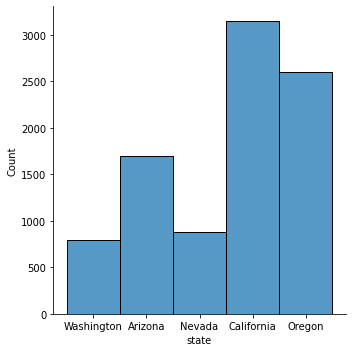

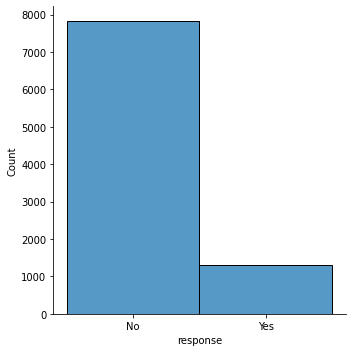

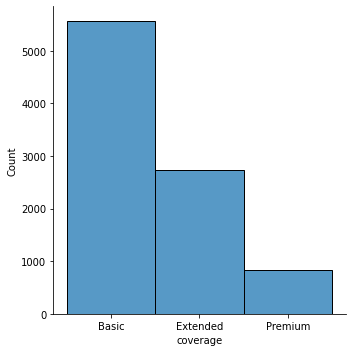

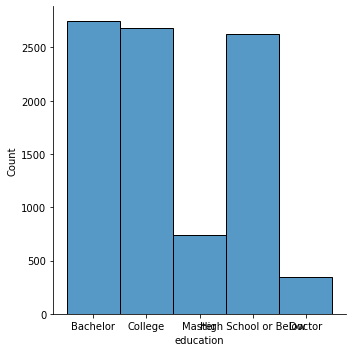

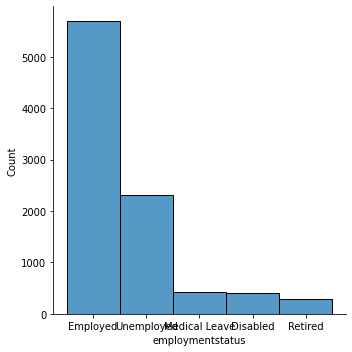

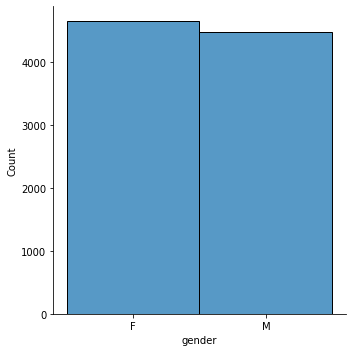

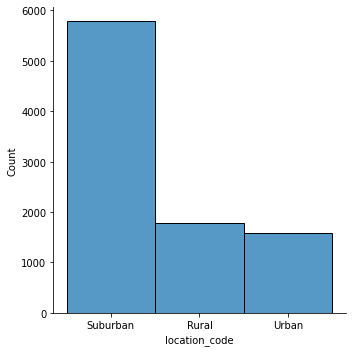

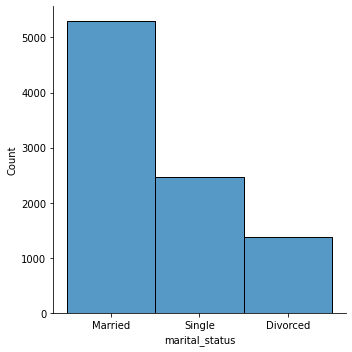

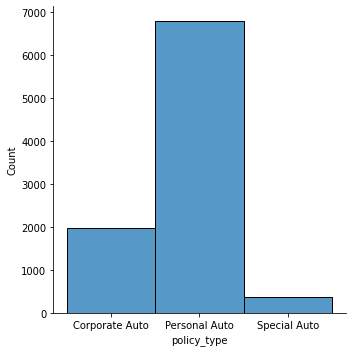

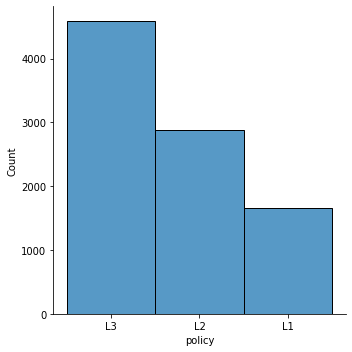

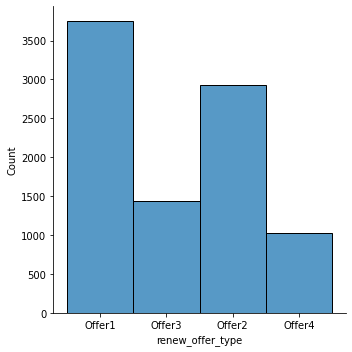

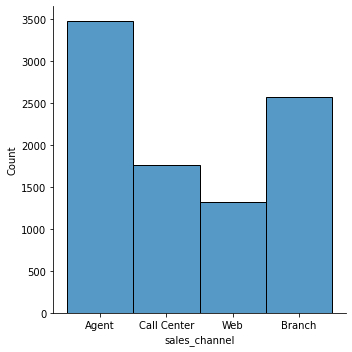

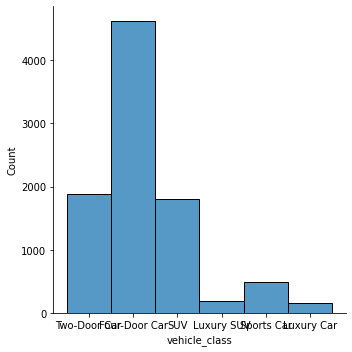

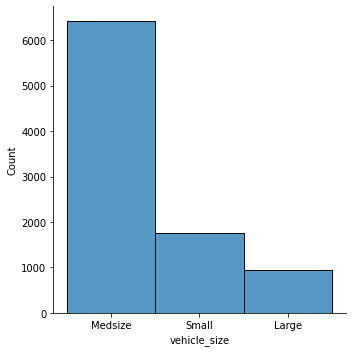

In [53]:
discreteplot(categorical_df)

##     There might be some columns that seem to be redundant, check their values to be sure. What should we do with them?

The 'vehicle_class' seems to have relatively many values that are relatively small:

In [54]:
categorical_df['vehicle_class'].value_counts()

Four-Door Car    4621
Two-Door Car     1886
SUV              1796
Sports Car        484
Luxury SUV        184
Luxury Car        163
Name: vehicle_class, dtype: int64

I think I will group 'Sports Car', 'Luxury SUV' and 'Luxury Car' together as the single category 'Luxury'.

In [55]:
newvehicleclass = []
for row in categorical_df['vehicle_class']:
    if row == "Sports Car" or row == "Luxury SUV" or row == "Luxury Car":
        newvehicleclass.append("Luxury")
    else: 
        newvehicleclass.append(row)

In [56]:
len(newvehicleclass)

9134

In [57]:
categorical_df['vehicle_class'] = newvehicleclass

##     Plot time variable. Can you extract something from it?

This column was never explicitly and intentionally dropped, but just sort of disappeared along the way. I'll resuscitate it here:

In [58]:
customer_df['effective_to_date']

0      2011-02-24
1      2011-01-31
2      2011-02-19
3      2011-01-20
4      2011-02-03
          ...    
9129   2011-02-10
9130   2011-02-12
9131   2011-02-06
9132   2011-02-03
9133   2011-02-14
Name: effective_to_date, Length: 9134, dtype: datetime64[ns]

The most likely candidate for a way to plot this is as the x-axis, against some other value on the y axis. I'll try that for a few features.

<AxesSubplot:xlabel='effective_to_date', ylabel='monthly_premium_auto'>

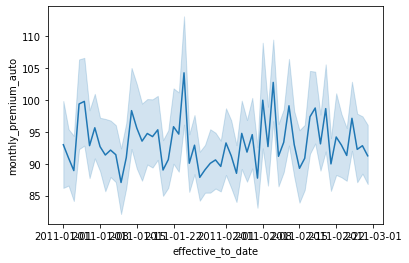

In [59]:
sns.lineplot(x = customer_df['effective_to_date'], y = customer_df['monthly_premium_auto'])

<AxesSubplot:xlabel='effective_to_date', ylabel='months_since_policy_inception'>

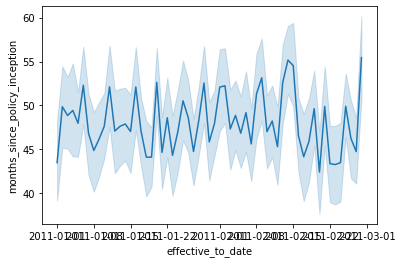

In [60]:
sns.lineplot(x = customer_df['effective_to_date'], y = customer_df['months_since_policy_inception'])

This is odd - I had expected there to be more of a correlation (with the higher number of months since inception also being the lower effective-to date). But this looks like a random-ish distribution.

<AxesSubplot:xlabel='effective_to_date', ylabel='income'>

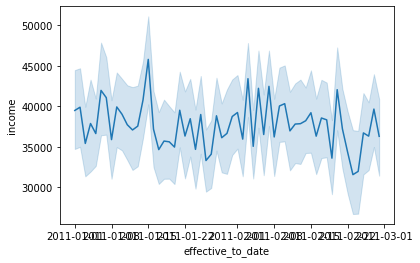

In [61]:
sns.lineplot(x = customer_df['effective_to_date'], y = customer_df['income'])

In [62]:
customer_df.columns

Index(['customer', 'state', 'customer_lifetime_value', 'response', 'coverage',
       'education', 'effective_to_date', 'employmentstatus', 'gender',
       'income', 'location_code', 'marital_status', 'monthly_premium_auto',
       'months_since_last_claim', 'months_since_policy_inception',
       'number_of_open_complaints', 'number_of_policies', 'policy_type',
       'policy', 'renew_offer_type', 'sales_channel', 'total_claim_amount',
       'vehicle_class', 'vehicle_size'],
      dtype='object')

I'm not seeing anything emerge here, but I could be missing something. Looking forward to discussing the lab.

#  
#  
#  
# Lab 4. Comparing regression models

##    In this final lab, we will model our data. Import sklearn train_test_split and separate the data.

In [63]:
from sklearn.model_selection import train_test_split

I'll do the X-y split first:

In [64]:
X_cat = categorical_df.copy()
X_num = df.drop(columns = ['customer_lifetime_value'].copy())
y = df['customer_lifetime_value'].copy()

In [65]:
X_num.head()

,income,monthly_premium_auto,total_claim_amount,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies
0,56274.0,69,384.811147,32,5,0,1
2,48767.0,108,566.472247,18,38,0,2
4,43836.0,73,138.130879,12,44,0,1
5,62902.0,69,159.383042,14,94,0,2
6,55350.0,67,321.600000,0,13,0,9


In [66]:
X = pd.concat([X_cat, customer_df['effective_to_date'], X_num], axis = 1).copy()

X.head()

# I added the effective_to_date column again. It got dropped because (apparently) datetime is neither object nor np.number

,state,response,coverage,education,employmentstatus,gender,location_code,marital_status,policy_type,policy,renew_offer_type,sales_channel,vehicle_class,vehicle_size,effective_to_date,income,monthly_premium_auto,total_claim_amount,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies
0,Washington,No,Basic,Bachelor,Employed,F,Suburban,Married,Corporate Auto,L3,Offer1,Agent,Two-Door Car,Medsize,2011-02-24,56274.000000,69,384.811147,32,5,0,1
1,Arizona,No,Extended,Bachelor,Unemployed,F,Suburban,Single,Personal Auto,L3,Offer3,Agent,Four-Door Car,Medsize,2011-01-31,24594.838967,94,1131.464935,13,42,0,8
2,Nevada,No,Premium,Bachelor,Employed,F,Suburban,Married,Personal Auto,L3,Offer1,Agent,Two-Door Car,Medsize,2011-02-19,48767.000000,108,566.472247,18,38,0,2
3,California,No,Basic,Bachelor,Unemployed,M,Suburban,Married,Corporate Auto,L2,Offer1,Call Center,SUV,Medsize,2011-01-20,46947.010707,106,529.881344,18,65,0,7
4,Washington,No,Basic,Bachelor,Employed,M,Rural,Single,Personal Auto,L1,Offer1,Agent,Four-Door Car,Medsize,2011-02-03,43836.000000,73,138.130879,12,44,0,1


### Here comes the train-test split:

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=666)

##    We will start with removing outliers, if you have not already done so. We have discussed different methods to remove outliers. Use the one you feel more comfortable with, define a function for that. Use the function to remove the outliers and apply it to the dataframe.

I tinkered around with this above for *total_claim_amount*, but neither a cutoff nor a logistical regression really gave me much to work with. 

##    Create a copy of the dataframe for the data wrangling.

In [68]:
X_train_num = X_train.select_dtypes(include = np.number)
X_train_cat = X_train.select_dtypes(include = object)

In [69]:
X_test_num = X_test.select_dtypes(include = np.number)
X_test_cat = X_test.select_dtypes(include = object)

##    Normalize the continuous variables. You can use any one method you want.

In [70]:
scaler = MinMaxScaler().fit(X_train_num)


def normalize(dataframe):
    normalized = scaler.transform(dataframe)
    X_transformed = pd.DataFrame(data = normalized, columns = dataframe.columns)
    return X_transformed

In [71]:
X_train_num_normalized = normalize(X_train_num)
X_test_num_normalized = normalize(X_test_num)

In [72]:
# Check if that looks good
display(X_train_num_normalized)
display(X_test_num_normalized)

,income,monthly_premium_auto,total_claim_amount,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies
0,0.981879,0.194093,0.162811,0.114286,0.464646,0.0,0.750
1,0.998935,0.206751,0.191290,0.657143,0.252525,0.2,0.875
2,0.824357,0.683544,0.339613,0.142857,0.565657,0.0,0.375
3,0.432653,0.793249,0.831444,0.628571,0.060606,0.0,0.250
4,0.449095,0.054852,0.193029,1.000000,0.595960,0.0,0.000
...,...,...,...,...,...,...,...
7302,0.442200,0.295359,0.227815,0.028571,0.575758,0.0,0.250
7303,0.334688,0.223629,0.198247,0.171429,0.272727,0.0,0.250
7304,0.586370,0.025316,0.048565,0.285714,0.717172,0.0,0.250
7305,0.524190,0.113924,0.153024,0.457143,0.282828,0.4,0.750


,income,monthly_premium_auto,total_claim_amount,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies
0,0.562156,0.050633,0.060315,0.228571,0.494949,0.0,0.000
1,0.239797,0.160338,0.237716,0.457143,0.000000,0.4,0.000
2,0.944841,0.012658,0.111281,0.400000,0.393939,0.0,0.000
3,0.761874,0.097046,0.025804,0.971429,0.020202,0.0,0.125
4,0.600065,0.130802,0.159982,0.314286,0.575758,0.0,0.000
...,...,...,...,...,...,...,...
1822,0.975935,0.050633,0.126935,0.171429,0.858586,0.0,0.125
1823,0.478506,0.012658,0.000402,0.285714,1.000000,0.4,0.250
1824,0.335762,0.202532,0.189550,0.371429,0.131313,0.0,0.875
1825,0.298169,0.320675,0.238251,0.057143,0.404040,0.0,0.500


##    Encode the categorical variables 

I'll check which ones I'll want to use one hot encoding on, and which ones I'll want to encode as ordinals:

In [73]:
X_train_cat.head()

,state,response,coverage,education,employmentstatus,gender,location_code,marital_status,policy_type,policy,renew_offer_type,sales_channel,vehicle_class,vehicle_size
1855,Arizona,No,Basic,Bachelor,Employed,M,Urban,Divorced,Personal Auto,L3,Offer3,Call Center,SUV,Small
13,Arizona,Yes,Basic,High School or Below,Employed,M,Suburban,Married,Corporate Auto,L3,Offer2,Branch,SUV,Medsize
3909,California,No,Extended,High School or Below,Employed,F,Urban,Married,Personal Auto,L3,Offer4,Branch,Luxury,Medsize
2895,Arizona,No,Extended,High School or Below,Employed,F,Suburban,Single,Special Auto,L3,Offer1,Agent,Luxury,Medsize
545,Oregon,No,Basic,High School or Below,Unemployed,F,Suburban,Single,Personal Auto,L1,Offer1,Agent,Four-Door Car,Small


In [74]:
# Ordinals: 
    # Coverage
    # Education?
    # Policy?
    # Vehicle size

'Coverage' and 'vehicle size' are very obviously fit for an ordinal encoding. Education might be - higher educated being a larger number - and policy might also be (L1-L3 presumably being different levels of coverage). 

Although the instructions say to treat employment and location code as ordinals, I will be disobedient and not do that. 

(Also a note: it would have made more sense to do this before the train-test split, to save a few steps)

In [75]:
X_train_cat['coverage'].value_counts()

Basic       4428
Extended    2215
Premium      664
Name: coverage, dtype: int64

In [76]:
X_train_cat["coverage"] = X_train_cat["coverage"].map({"Basic" : 0, "Extended" : 1, "Premium" : 2})

In [77]:
X_test_cat["coverage"] = X_test_cat["coverage"].map({"Basic" : 0, "Extended" : 1, "Premium" : 2})

In [78]:
X_train_cat['education'].value_counts()

Bachelor                2227
College                 2132
High School or Below    2106
Master                   579
Doctor                   263
Name: education, dtype: int64

(Note: I'm assuming that college ranks below bachelor, as college could include drop-outs or associate's degrees)

In [79]:
X_train_cat["education"] = X_train_cat["education"].map({"High School or Below" : 0, "College" : 1, "Bachelor" : 2, "Master": 3, "Doctor": 4})

In [80]:
X_test_cat["education"] = X_test_cat["education"].map({"High School or Below" : 0, "College" : 1, "Bachelor" : 2, "Master": 3, "Doctor": 4})

In [81]:
X_train_cat['vehicle_size'].value_counts()

Medsize    5153
Small      1407
Large       747
Name: vehicle_size, dtype: int64

In [82]:
X_train_cat["vehicle_size"] = X_train_cat["vehicle_size"].map({"Small" : 0, "Medsize" : 1, "Large" : 2})

In [83]:
X_test_cat["vehicle_size"] = X_test_cat["vehicle_size"].map({"Small" : 0, "Medsize" : 1, "Large" : 2})

In [84]:
X_train_cat['policy'].value_counts()

L3    3659
L2    2307
L1    1341
Name: policy, dtype: int64

In [85]:
X_train_cat["policy"] = X_train_cat["policy"].map({"L1" : 0, "L2" : 1, "L3" : 2})

In [86]:
X_test_cat["policy"] = X_test_cat["policy"].map({"L1" : 0, "L2" : 1, "L3" : 2})

In [102]:
# I'll reset the indexes again (I didn't at first, which led to a NaN-apocalypse later on)

In [103]:
X_train_cat.reset_index(inplace=True, drop=True)

In [104]:
X_test_cat.reset_index(inplace=True, drop=True)

In [106]:
X_train_cat

,state,response,coverage,education,employmentstatus,gender,location_code,marital_status,policy_type,policy,renew_offer_type,sales_channel,vehicle_class,vehicle_size
0,Arizona,No,0,2,Employed,M,Urban,Divorced,Personal Auto,2,Offer3,Call Center,SUV,0
1,Arizona,Yes,0,0,Employed,M,Suburban,Married,Corporate Auto,2,Offer2,Branch,SUV,1
2,California,No,1,0,Employed,F,Urban,Married,Personal Auto,2,Offer4,Branch,Luxury,1
3,Arizona,No,1,0,Employed,F,Suburban,Single,Special Auto,2,Offer1,Agent,Luxury,1
4,Oregon,No,0,0,Unemployed,F,Suburban,Single,Personal Auto,0,Offer1,Agent,Four-Door Car,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7302,Oregon,No,1,1,Employed,F,Suburban,Divorced,Personal Auto,2,Offer1,Agent,Luxury,1
7303,California,No,0,0,Employed,F,Suburban,Married,Personal Auto,1,Offer4,Agent,Luxury,1
7304,Arizona,No,0,1,Employed,F,Rural,Single,Personal Auto,2,Offer2,Agent,Four-Door Car,1
7305,Arizona,No,1,2,Unemployed,M,Suburban,Married,Personal Auto,1,Offer1,Branch,Four-Door Car,0


Next, isolate the ones that I want to One-Hot encode

In [107]:
X_train_cat2 = X_train_cat.select_dtypes(include = object)

In [108]:
X_test_cat2 = X_test_cat.select_dtypes(include = object)

In [109]:
from sklearn.preprocessing import OneHotEncoder

In [110]:
encoder = OneHotEncoder().fit(X_train_cat2)

In [111]:
encoded = encoder.transform(X_train_cat2).toarray()

X_train_cat_enc = pd.DataFrame(encoded)

In [112]:
encoded = encoder.transform(X_test_cat2).toarray()

X_test_cat_enc = pd.DataFrame(encoded)

In [113]:
X_train_cat_enc

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7302,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7303,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7304,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7305,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [114]:
# Concatenate the categoricals again

In [115]:
X_train_cat_transformed = pd.concat([X_train_cat_enc, X_train_cat.select_dtypes(include = np.number)], axis = 1)

In [117]:
X_test_cat_transformed = pd.concat([X_test_cat_enc, X_test_cat.select_dtypes(include = np.number)], axis = 1)

In [118]:
X_train_cat_transformed

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,coverage,education,policy,vehicle_size
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,2,2,0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,2,1
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,2,1
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,2,1
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7302,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,2,1
7303,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,1,1
7304,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1,2,1
7305,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1,2,1,0


##    The time variable can be useful. Try to transform its data into a useful one. Hint: Day week and month as integers might be useful.

I'll be a good boy and transform this, but I am not at all convinced that there is anything useful in here - or that the day/week/month integers will add anything. So I'll follow the instructions here, but I'll leave this out from the final analysis.

In [119]:
X_train['effective_to_date']

1855   2011-02-08
13     2011-01-10
3909   2011-01-18
2895   2011-02-01
545    2011-02-06
          ...    
1469   2011-01-09
8262   2011-01-28
2878   2011-02-19
7597   2011-01-27
6380   2011-02-11
Name: effective_to_date, Length: 7307, dtype: datetime64[ns]

In [131]:
#Just to be safe, I'll reset the index for X_train and X_test right away

X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)

In [140]:
X_train['day'] = X_train['effective_to_date'].dt.day
X_train['month'] = X_train['effective_to_date'].dt.month
X_train['week'] = X_train['effective_to_date'].dt.isocalendar().week

0        8
1       10
2       18
3        1
4        6
        ..
7302     9
7303    28
7304    19
7305    27
7306    11
Name: day, Length: 7307, dtype: int64

In [133]:
X_test['day'] = X_test['effective_to_date'].dt.day
X_test['month'] = X_test['effective_to_date'].dt.month
X_test['week'] = X_test['effective_to_date'].dt.isocalendar().week

##    Since the model will only accept numerical data, check and make sure that every column is numerical, if some are not, change it using encoding.

In [ ]:
# First I'll concatenate everything I have so far into one big dataframe
# (OK, two big dataframes - one for 'test', one for 'train')

In [141]:
X_train_transformed = pd.concat([X_train_cat_transformed, X_train_num_normalized], axis = 1)
X_train_transformed

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,coverage,education,policy,vehicle_size,income,monthly_premium_auto,total_claim_amount,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,2,2,0,0.981879,0.194093,0.162811,0.114286,0.464646,0.0,0.750
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,2,1,0.998935,0.206751,0.191290,0.657143,0.252525,0.2,0.875
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,2,1,0.824357,0.683544,0.339613,0.142857,0.565657,0.0,0.375
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,2,1,0.432653,0.793249,0.831444,0.628571,0.060606,0.0,0.250
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0.449095,0.054852,0.193029,1.000000,0.595960,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7302,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,2,1,0.442200,0.295359,0.227815,0.028571,0.575758,0.0,0.250
7303,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,1,1,0.334688,0.223629,0.198247,0.171429,0.272727,0.0,0.250
7304,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1,2,1,0.586370,0.025316,0.048565,0.285714,0.717172,0.0,0.250
7305,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1,2,1,0,0.524190,0.113924,0.153024,0.457143,0.282828,0.4,0.750


In [155]:
X_test_transformed = pd.concat([X_test_cat_transformed, X_test_num_normalized], axis = 1)
X_test_transformed

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,coverage,education,policy,vehicle_size,income,monthly_premium_auto,total_claim_amount,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,1,0,2,0.562156,0.050633,0.060315,0.228571,0.494949,0.0,0.000
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1,1,2,1,0.239797,0.160338,0.237716,0.457143,0.000000,0.4,0.000
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,1,1,1,0.944841,0.012658,0.111281,0.400000,0.393939,0.0,0.000
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,3,1,1,0.761874,0.097046,0.025804,0.971429,0.020202,0.0,0.125
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,2,2,0,0.600065,0.130802,0.159982,0.314286,0.575758,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,2,1,1,0.975935,0.050633,0.126935,0.171429,0.858586,0.0,0.125
1823,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,2,1,1,0.478506,0.012658,0.000402,0.285714,1.000000,0.4,0.250
1824,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,4,2,1,0.335762,0.202532,0.189550,0.371429,0.131313,0.0,0.875
1825,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,4,0,1,0.298169,0.320675,0.238251,0.057143,0.404040,0.0,0.500


In [156]:
display(X_train_transformed.info())
display(X_test_transformed.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7307 entries, 0 to 7306
Data columns (total 46 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   0                              7307 non-null   float64
 1   1                              7307 non-null   float64
 2   2                              7307 non-null   float64
 3   3                              7307 non-null   float64
 4   4                              7307 non-null   float64
 5   5                              7307 non-null   float64
 6   6                              7307 non-null   float64
 7   7                              7307 non-null   float64
 8   8                              7307 non-null   float64
 9   9                              7307 non-null   float64
 10  10                             7307 non-null   float64
 11  11                             7307 non-null   float64
 12  12                             7307 non-null   f

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 46 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   0                              1827 non-null   float64
 1   1                              1827 non-null   float64
 2   2                              1827 non-null   float64
 3   3                              1827 non-null   float64
 4   4                              1827 non-null   float64
 5   5                              1827 non-null   float64
 6   6                              1827 non-null   float64
 7   7                              1827 non-null   float64
 8   8                              1827 non-null   float64
 9   9                              1827 non-null   float64
 10  10                             1827 non-null   float64
 11  11                             1827 non-null   float64
 12  12                             1827 non-null   f

None

##    Try a simple linear regression with all the data to see whether we are getting good results.

In [148]:
from sklearn.linear_model import LinearRegression

In [150]:
reg = LinearRegression().fit(X_train_transformed, y_train)
reg.score(X_train_transformed, y_train)

/Users/work/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/work/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


0.00475756644797809

In [151]:
# This is a very poor score.

In [158]:
reg.score(X_test_transformed, y_test)

/Users/work/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


-0.010648930012687963

In [ ]:
# This score is even poorer.

(The warning is because I did have both numbers and strings as column names (numbers from OneHotEncoding, strings from the numericals) )

##    Great! Now define a function that takes a list of models and train (and tests) them so we can try a lot of them without repeating code.

In [174]:
def modelling(list_of_models):
    for model in list_of_models: 
        print("Applying", model)
        model.fit(X_train_transformed, y_train)
        print("Score for training data: ", model.score(X_train_transformed, y_train))
        print("Score for test data: ", model.score(X_test_transformed, y_test))
        print("\n")
    return
        

##    Use the function to check LinearRegressor and KNeighborsRegressor.

In [175]:
from sklearn.neighbors import KNeighborsRegressor

KNN = KNeighborsRegressor(n_neighbors=3)
lm = LinearRegression()

modellist = [KNN, lm]

In [176]:
modelling(modellist)

Applying KNeighborsRegressor(n_neighbors=3)
Score for training data:  0.3245019679469212
Score for test data:  -0.2751781995799143


Applying LinearRegression()
Score for training data:  0.00475756644797809
Score for test data:  -0.010648930012687963




/Users/work/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/work/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/work/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/work/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be rais

##    You can check also the MLPRegressor for this task!

In [177]:
from sklearn.neural_network import MLPRegressor

In [178]:
mlp = MLPRegressor(random_state=1, max_iter=500)
modellist.append(mlp)

In [179]:
modelling(modellist)

Applying KNeighborsRegressor(n_neighbors=3)
Score for training data:  0.3245019679469212
Score for test data:  -0.2751781995799143


Applying LinearRegression()
Score for training data:  0.00475756644797809
Score for test data:  -0.010648930012687963


Applying MLPRegressor(max_iter=500, random_state=1)


/Users/work/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/work/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/work/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/work/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be rais

Score for training data:  0.005997514294091233
Score for test data:  -0.005275063889718767




/Users/work/Library/Python/3.10/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/work/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/work/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


##    Check and discuss the results.

None of these scores are great - I'd have to go back to re-clean (and likely drop) some of the data to get a better model. 

The KNN Regression does best on the training data, but worst on the test data - so it's overtrained. 

Another insight: if you do the train-test split before your data is all pretty and clean, you're going to have to do a lot of steps twice. The organization of this lab kind of forced that on me - but when I do my own regressions, I'll make sure not to do the train-test split before it is strictly necessary.

(Another issue with this lab is that there are many non-functional cells above, where I'm just generating plots and retrieving information - re-running everything is a bit of a hassle, but going back and cleaning stuff is an even bigger hassle.)